# Simulacion de Agendamiento
## Agencia San Miguel, junio 2019

In [1]:
from center import Center
from vehicle import Vehicle
from patient import Patient
from doctor import Doctor
from constants import *
import basicfunc as bf
from datetime import datetime
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Configuramos graficos
sns.set()  # estilo por defecto de seaborn
sns.set_style() #ej: white, whitegrid
sns.set_context('paper', font_scale=1.6) # ej: paper, notebook
plt.rcParams['figure.figsize'] = (10, 6)  # tamaño por defecto de las figuras

In [4]:
%%time

"""
dates_list = ["2019-06-03","2019-06-04","2019-06-05","2019-06-06","2019-06-07",
              "2019-06-10","2019-06-11","2019-06-12","2019-06-13","2019-06-14",
              "2019-06-17","2019-06-18","2019-06-19","2019-06-20","2019-06-21",
              "2019-06-24","2019-06-25","2019-06-26","2019-06-27","2019-06-28"]
"""
dates_list=['2019-12-17','2019-11-28','2019-10-30','2019-11-18','2019-12-12','2019-12-23','2019-07-10','2019-07-29','2019-10-23','2019-06-21','2019-07-03','2019-07-15','2019-07-18','2019-07-19','2019-07-24','2019-08-26','2019-08-27','2019-08-28','2019-08-29','2019-09-16','2019-11-04','2019-11-08','2019-06-07','2019-11-12','2019-07-31','2019-08-01','2019-08-02','2019-08-05','2019-08-07','2019-08-09','2019-08-12','2019-08-14','2019-08-16','2019-08-19','2019-08-20','2019-08-21','2019-08-22','2019-08-23','2019-08-30','2019-09-02','2019-09-04','2019-09-05','2019-09-06','2019-08-08','2019-09-03','2019-06-03','2019-06-04','2019-06-05','2019-06-06','2019-06-10','2019-06-11','2019-06-12','2019-06-24','2019-06-25','2019-06-27','2019-07-01','2019-07-02','2019-07-09','2019-07-11','2019-07-17','2019-07-25','2019-08-06','2019-08-13','2019-09-09','2019-09-11','2019-09-13','2019-09-23','2019-09-24','2019-09-25','2019-09-26','2019-09-30','2019-10-02','2019-10-08','2019-10-11','2019-10-14','2019-10-17','2019-11-06','2019-10-28','2019-10-01','2019-06-14','2019-06-17','2019-06-19','2019-06-20','2019-06-26','2019-07-08','2019-07-12','2019-07-22','2019-07-23','2019-09-10','2019-09-12','2019-09-17','2019-10-03','2019-10-04','2019-10-07','2019-10-09','2019-10-10','2019-10-15','2019-10-16','2019-10-21','2019-06-18','2019-12-20','2019-07-04','2019-07-05','2019-07-26','2019-07-30','2019-11-14','2019-06-13','2019-06-28','2019-09-27','2019-10-22','2019-10-24','2019-10-29','2019-12-05','2019-11-13','2019-12-02','2019-10-25','2019-10-18','2019-11-15','2019-11-11','2020-01-10','2019-11-25','2019-12-13','2020-01-08','2019-11-26','2019-11-07','2019-11-05','2019-12-26','2020-01-09','2019-12-11','2020-01-13','2020-01-17','2020-01-14','2020-01-15','2020-01-16','2019-12-06','2019-11-19','2020-01-20','2019-11-21','2019-12-10','2019-12-18','2020-01-03','2020-01-21','2020-01-22','2020-01-23','2020-01-24','2020-01-27','2019-11-20','2019-12-09','2019-12-19','2019-12-16','2019-12-27','2020-01-06','2019-11-27','2020-01-29','2019-12-31','2019-12-03','2019-12-24','2019-12-04','2020-01-07','2019-11-22','2020-01-02','2019-11-29','2020-01-28','2020-01-30','2020-01-31','2019-12-30']
dates_list= [d for d in dates_list if d.split("-")[1]=="06"]
dates_list.sort()

folder = "input_junio2019_no_kine_mod"

patients_stats = []
vehicles_stats = []

attention_window = {} # {patient_id: (window_start, window_end)}
transportation_window = {} # {patient_id: (window_start, window_end)}

for date in dates_list:
    print(f"\nCalculando para {date}...")

    doctors_filepath = folder + "/attention_capacity.csv"
    doctors = Doctor.from_xls(doctors_filepath, date)

    vehicles_filepath = folder + "/vehicles.csv"
    vehicles = Vehicle.from_xls(vehicles_filepath, date)

    patients_filepath = folder + "/Patients.csv"
    patients = Patient.from_xls(patients_filepath, date)
    
    # se muestra la oferta y demanda de atenciones de cada doctor
    for doc in doctors:
        count = 0
        for pat in patients:
            for att in pat.attention_orders:
                if doc.attention_type == att.attention_type == PRIMARY_ATTENTION:
                    count+=1
                elif att.id_required_doctor == doc.id:
                    count+=1

        print(f"{doc}: se demandan {count} de {len(doc.agenda)} citas")
    
    # se cargan las ventanas de tiempo existentes
    for pat in patients:
        if pat.id in attention_window:
            window_start, window_end = attention_window[pat.id]
            
            for att_order in pat.attention_orders:
                att_order.window_start = window_start
                att_order.window_end = window_end
        
        if pat.transport and pat.id in transportation_window:
            window_start, window_end = transportation_window[pat.id]
            pat.pickup_order.window_start = window_start
            pat.pickup_order.window_end = window_end
            
    # se crea y simula el sistema
    c = Center("SanMiguel", -33.487056, -70.647836, verbose=False)
    _ = c.add_patients(patients)
    _ = c.add_doctors(doctors)
    _ = c.add_vehicles(vehicles)
    
    c.simulate_events()
    print(c)
    
    # se guardan estadisticas
    for veh in list(c.vehicles.values()) + list(c.taxis.values()):
        dict_stats = veh.get_stats()
        dict_stats["date"] = date
        vehicles_stats.append(dict_stats)
    
    for pat in c.patients.values():
        dict_stats = pat.get_stats()
        dict_stats["date"] = date
        patients_stats.append(dict_stats)
        
        # se guardan las ventanas de tiempo en caso de no existir una previa
        if pat.id not in attention_window and pat.attention_time is not None:
            window_start = max(START_TIME, pat.attention_time -1*30)
            window_end = min(END_TIME, pat.attention_time + 1*30)
            attention_window[pat.id] = (window_start, window_end)
            
        if pat.transport and pat.id not in transportation_window and pat.pickup_order.trip is not None:
            window_start = max(START_TIME, pat.pickup_order.trip.start_time - 1*60)
            window_end = min(END_TIME, pat.pickup_order.trip.start_time + 1*60)
            transportation_window[pat.id] = (window_start, window_end)

file_time = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
df_patients = pd.DataFrame(patients_stats)
df_vehicles = pd.DataFrame(vehicles_stats)
df_tptwindows = pd.DataFrame(transportation_window).T
df_attwindows = pd.DataFrame(attention_window).T

df_patients.to_excel(f"{folder}/RegularTimeWindow/output_patients_{file_time}.xlsx")
df_vehicles.to_excel(f"{folder}/RegularTimeWindow/output_vehicles_{file_time}.xlsx")
df_tptwindows.to_excel(f"{folder}/RegularTimeWindow/output_tptwindows_{file_time}.xlsx")
df_attwindows.to_excel(f"{folder}/RegularTimeWindow/output_attwindows_{file_time}.xlsx")


Calculando para 2019-06-03...
Doctor(1, Primaria): se demandan 17 de 19 citas
Doctor(2, Kinesiologia): se demandan 65 de 76 citas
Estado del centro SanMiguel:
- Reloj: 23:59
- Espera pickup (0): []
- Espera dropoff (0): []
- Pacientes en el centro (0): []
- Pendiente pickup (0): []
- Pendiente dropoff (0): []
- Espera agendamiento sin transporte (0): []
- Pacientes completados: 81

Calculando para 2019-06-04...
Doctor(1, Primaria): se demandan 20 de 20 citas
Doctor(2, Kinesiologia): se demandan 65 de 76 citas
Estado del centro SanMiguel:
- Reloj: 23:59
- Espera pickup (0): []
- Espera dropoff (0): []
- Pacientes en el centro (0): []
- Pendiente pickup (0): []
- Pendiente dropoff (0): []
- Espera agendamiento sin transporte (0): []
- Pacientes completados: 83

Calculando para 2019-06-05...
Doctor(1, Primaria): se demandan 20 de 20 citas
Doctor(2, Kinesiologia): se demandan 69 de 76 citas
Estado del centro SanMiguel:
- Reloj: 23:59
- Espera pickup (0): []
- Espera dropoff (0): []
- Paci

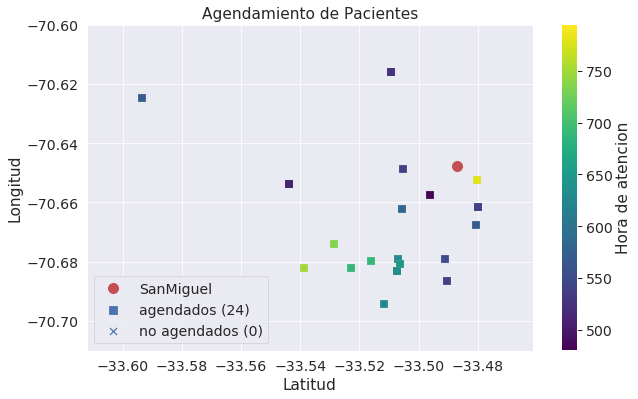

In [5]:
# coordenadas de pacientes agendados
lat = []
lon = []
attention_time = [] # hora de atencion

# coordenadas de pacientes NO agendados
not_lat = []
not_lon = []

for pat in patients:
    if pat.transport:
        pat_lat = float(pat.pickup_order.lat)
        pat_lon = float(pat.pickup_order.lon)
        if pat.release_time is not None:
            lat.append(pat_lat)
            lon.append(pat_lon)
            attention_time.append(pat.attention_time)
        else:
            not_lat.append(pat_lat)
            not_lon.append(pat_lon)

plt.figure()
plt.title("Agendamiento de Pacientes")
plt.scatter(lat, lon, s=50, c=attention_time, marker="s", cmap="viridis", label=f"agendados ({len(lat)})")
plt.colorbar(label="Hora de atencion")
plt.scatter(not_lat, not_lon, s=50, marker="x", label=f"no agendados ({len(not_lat)})")
plt.plot(c.lat, c.lon, "ro", label=c.id, markersize=10)
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.axis('equal')
plt.legend()
plt.show()

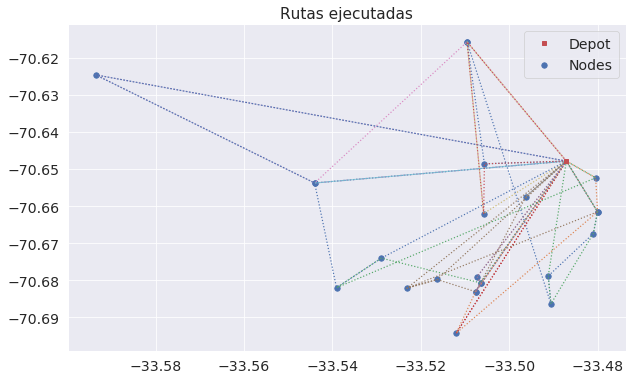

In [6]:
plt.figure()
plt.title("Rutas ejecutadas")

regular_routes = [r for v in c.vehicles.values() for r in v.routes]
taxi_routes = [r for v in c.taxis.values() for r in v.routes]
routes = regular_routes + taxi_routes

for r in routes:
    lats = [float(c.lat)]
    lons = [float(c.lon)]
    
    for trip in r.trips:
        lats.append(float(trip.transportation_order.lat))
        lons.append(float(trip.transportation_order.lon))
        
    lats.append(float(c.lat))
    lons.append(float(c.lon))
    plt.plot(lats, lons,":")
    
plt.plot(c.lat, c.lon, "rs", label="Depot")

pats_lat = [float(pat.pickup_order.lat) for pat in patients if pat.transport]
pats_lon = [float(pat.pickup_order.lon) for pat in patients if pat.transport]
plt.scatter(pats_lat, pats_lon, s=30, label="Nodes")
plt.legend()
plt.show()

In [7]:
routes.sort(key=lambda r: r.vehicle.id)

count_pickup = 0
count_dropoff = 0

for r in routes:
    print(f"{r.vehicle.id} (Capacidad: {r.vehicle.capacity})")
    print(f"{bf.int2strtime(r.start_time)}-{bf.int2strtime(r.end_time)}")
    
    for trip in r.trips:
        print("\t", trip, trip.transportation_order._patient)
        if trip.type == "pickup":
            count_pickup +=1
        else:
            count_dropoff += 1
        
    print()
    
print("Total pacientes:", len([pat for pat in patients if pat.transport]))
print("Conteo pickup:", count_pickup)
print("Conteo dropoff:", count_dropoff)

HH-114-1 (Capacidad: 3)
07:00-07:19
	 (07:10, pickup) Patient(1006403948)

HH-114-1 (Capacidad: 3)
07:49-08:39
	 (08:06, pickup) Patient(1005493603)
	 (08:24, pickup) Patient(1003313293)

HH-114-1 (Capacidad: 3)
09:09-09:50
	 (09:32, pickup) Patient(1006307860)

HH-114-1 (Capacidad: 3)
10:20-11:52
	 (10:41, pickup) Patient(1003141942)
	 (10:52, pickup) Patient(1004296708)
	 (11:01, dropoff) Patient(1006307860)
	 (11:24, dropoff) Patient(1003203443)

HH-114-1 (Capacidad: 3)
12:22-12:59
	 (12:36, dropoff) Patient(1005917116)

HH-116-1 (Capacidad: 6)
07:00-08:09
	 (07:23, pickup) Patient(1006307860)
	 (07:46, pickup) Patient(1003203443)

HH-116-1 (Capacidad: 6)
09:55-11:06
	 (10:16, pickup) Patient(1004003153)
	 (10:25, pickup) Patient(1006286334)
	 (10:36, pickup) Patient(1005917116)
	 (10:42, pickup) Patient(1006256982)
	 (10:52, dropoff) Patient(1006403948)

HH-116-1 (Capacidad: 6)
11:36-12:36
	 (11:54, dropoff) Patient(1006307860)
	 (12:16, dropoff) Patient(1003313293)

HH-130-1 (Capa

In [8]:
ptime = bf.int2strtime

for pat in patients:
    print(f"{pat} requiere {[att.attention_type for att in pat.attention_orders]}.")
    
    if pat.transport:

        if pat.pickup_order.trip is not None:
            pickup_time = pat.pickup_order.trip.start_time
            arrival_time = pat.pickup_order.trip.end_time
            print(f"--> Demora {ptime(arrival_time - pickup_time)} en llegar ({ptime(pickup_time)}-{ptime(arrival_time)})")

            if pat.attention_time is not None:
                print(f"--> Espera {ptime(pat.attention_time - arrival_time)} para atenderse")
                print(f"--> Demora {ptime(pat.release_time - pat.attention_time)} en atenderse")

                for att in pat.attention_orders:
                    if att.appointment is not None:
                        att_type = att.attention_type
                        start_time = att.appointment.start_time
                        end_time = att.appointment.end_time
                        print(f"\t {att_type} entre {ptime(start_time)} y {ptime(end_time)}")

                if pat.dropoff_order.trip is not None:
                    departure_time = pat.dropoff_order.trip.start_time
                    dropoff_time = pat.dropoff_order.trip.end_time
                    print(f"--> Espera {ptime(departure_time - pat.release_time)} para regresar")
                    print(f"--> Demora {ptime(dropoff_time - departure_time)} en regresar ({ptime(departure_time)}-{ptime(dropoff_time)})")

            else:
                print("--> No logra recibir atencion!")
        
    else:
        if pat.attention_time is not None:
            print(f"--> Demora {ptime(pat.release_time - pat.attention_time)} en atenderse")

            for att in pat.attention_orders:
                if att.appointment is not None:
                    att_type = att.attention_type
                    start_time = att.appointment.start_time
                    end_time = att.appointment.end_time
                    print(f"\t {att_type} entre {ptime(start_time)} y {ptime(end_time)}")
                    
        else:
            print("--> No logra recibir atencion!")
            
    print()

Patient(1006307860) requiere ['Primaria'].
--> Demora 00:18 en llegar (09:32-09:50)
--> Espera 00:10 para atenderse
--> Demora 00:15 en atenderse
	 Primaria entre 10:00 y 10:15
--> Espera 01:21 para regresar
--> Demora 00:18 en regresar (11:36-11:54)

Patient(1006307860) requiere ['Kinesiologia'].
--> Demora 00:46 en llegar (07:23-08:09)
--> Espera 00:21 para atenderse
--> Demora 01:00 en atenderse
	 Kinesiologia entre 08:30 y 09:30
--> Espera 00:50 para regresar
--> Demora 00:41 en regresar (10:20-11:01)

Patient(1006286334) requiere ['Kinesiologia'].
--> Demora 00:41 en llegar (10:25-11:06)
--> Espera 00:24 para atenderse
--> Demora 01:00 en atenderse
	 Kinesiologia entre 11:30 y 12:30
--> Espera 01:25 para regresar
--> Demora 00:35 en regresar (13:55-14:30)

Patient(1006416731) requiere ['Kinesiologia'].
--> Demora 01:00 en llegar (09:17-10:17)
--> Espera 00:13 para atenderse
--> Demora 01:00 en atenderse
	 Kinesiologia entre 10:30 y 11:30
--> Espera 02:10 para regresar
--> Demora 0

In [ ]:
# inputs folder
inputs_folder = "input_junio2019"

# fechas
dates_list = ["2019-06-03","2019-06-04","2019-06-05","2019-06-06","2019-06-07",
              "2019-06-10","2019-06-11","2019-06-12","2019-06-13","2019-06-14",
              "2019-06-17","2019-06-18","2019-06-19","2019-06-20","2019-06-21",
              "2019-06-24","2019-06-25","2019-06-26","2019-06-27","2019-06-28"]

# experimentos
kine_type = ["SiKine", "NoKine"]
window_type = ["RegularWindow","DoubleWindow","NoWindow"]
attention_window_width = [60*1, 60*2, 60*24]
transportation_window_width = [60*2, 60*4, 60*24]
results_dir = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
os.mkdir(results_dir)

for k in kine_type:
    for w, attwindow_width, tptwindow_width in zip(window_type, attention_window_width, transportation_window_width):
        print(f"Experimento: {k}, {w}")
        experiment_dir = f"{results_dir}/{k}_{w}"
        os.mkdir(experiment_dir)
        
        patients_stats = []
        vehicles_stats = []

        attention_window = {} # {patient_id: (window_start, window_end)}
        transportation_window = {} # {patient_id: (window_start, window_end)}
        
        for date in dates_list:
            
            print(f"\nCalculando para {date}...")

            doctors_filepath = inputs_folder+"/attention_capacity.csv"
            doctors = Doctor.from_xls(doctors_filepath, date)

            vehicles_filepath = inputs_folder+"/vehicles.csv"
            vehicles = Vehicle.from_xls(vehicles_filepath, date)

            patients_filepath = inputs_folder+"/Patients.csv"
            patients = Patient.from_xls(patients_filepath, date)

            # se muestra la oferta y demanda de atenciones de cada doctor
            for doc in doctors:
                count = 0
                for pat in patients:
                    for att in pat.attention_orders:
                        if doc.attention_type == att.attention_type == PRIMARY_ATTENTION:
                            count+=1
                        elif att.id_required_doctor == doc.id:
                            count+=1

                print(f"{doc}: se demandan {count} de {len(doc.agenda)} citas")

            # se cargan las ventanas de tiempo existentes
            for pat in patients:
                if pat.id in attention_window:
                    window_start, window_end = attention_window[pat.id]

                    for att_order in pat.attention_orders:
                        att_order.window_start = window_start
                        att_order.window_end = window_end

                if pat.transport and pat.id in transportation_window:
                    window_start, window_end = transportation_window[pat.id]
                    pat.pickup_order.window_start = window_start
                    pat.pickup_order.window_end = window_end

            # se crea y simula el sistema
            c = Center("SanMiguel", -33.487056, -70.647836, verbose=False)
            _ = c.add_patients(patients)
            _ = c.add_doctors(doctors)
            _ = c.add_vehicles(vehicles)

            c.simulate_events()
            print(c)

            # se guardan estadisticas
            for veh in list(c.vehicles.values()) + list(c.taxis.values()):
                dict_stats = veh.get_stats()
                dict_stats["date"] = date
                vehicles_stats.append(dict_stats)

            for pat in c.patients.values():
                dict_stats = pat.get_stats()
                dict_stats["date"] = date
                patients_stats.append(dict_stats)

                # se guardan las ventanas de tiempo en caso de no existir una previa
                if pat.id not in attention_window and pat.attention_time is not None:
                    window_start = max(START_TIME, pat.attention_time - 1*30)
                    window_end = min(END_TIME, pat.attention_time + 1*30)
                    attention_window[pat.id] = (window_start, window_end)

                if pat.transport and pat.id not in transportation_window and pat.pickup_order.trip is not None:
                    window_start = max(START_TIME, pat.pickup_order.trip.start_time - 1*60)
                    window_end = min(END_TIME, pat.pickup_order.trip.start_time + 1*60)
                    transportation_window[pat.id] = (window_start, window_end)

        file_time = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
        df_patients = pd.DataFrame(patients_stats)
        df_vehicles = pd.DataFrame(vehicles_stats)
        df_tptwindows = pd.DataFrame(transportation_window).T
        df_attwindows = pd.DataFrame(attention_window).T

        df_patients.to_excel(f"{folder}/RegularTimeWindow/output_patients_{file_time}.xlsx")
        df_vehicles.to_excel(f"{folder}/RegularTimeWindow/output_vehicles_{file_time}.xlsx")
        df_tptwindows.to_excel(f"{folder}/RegularTimeWindow/output_tptwindows_{file_time}.xlsx")
        df_attwindows.to_excel(f"{folder}/RegularTimeWindow/output_attwindows_{file_time}.xlsx")
        